<a href="https://colab.research.google.com/github/eceugru/Digital_Image_Processing/blob/main/Onisleme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hedeflenen nesneyi öne çıkaran ve haricini baskınlayan en iyi ön işlem adımları bulmak için 3 farklı pipline denenmiş ve pipline1 en iyi sonucu verdiği gözlemlenmiştir.
Pipeline 1: Normalizasyon -> Medyan Filtre -> Negatif Dönüşüm -> Sobel -> CLAHE

Pipeline 2: Gaussian Blur -> Histogram Eşitleme -> Gama Düzeltme

Pipeline 3: Median Filter -> CLAHE -> Unsharp Masking

Pipline 4: Normalization -> Histogram Equalization -> Keskinleştirme -> Gaussian Filter

Results for img2.png:
Pipeline 1 Score: 13.4885
Pipeline 2 Score: 80.6442
Pipeline 3 Score: 43.0524
Pipeline 4 Score: 42.7897


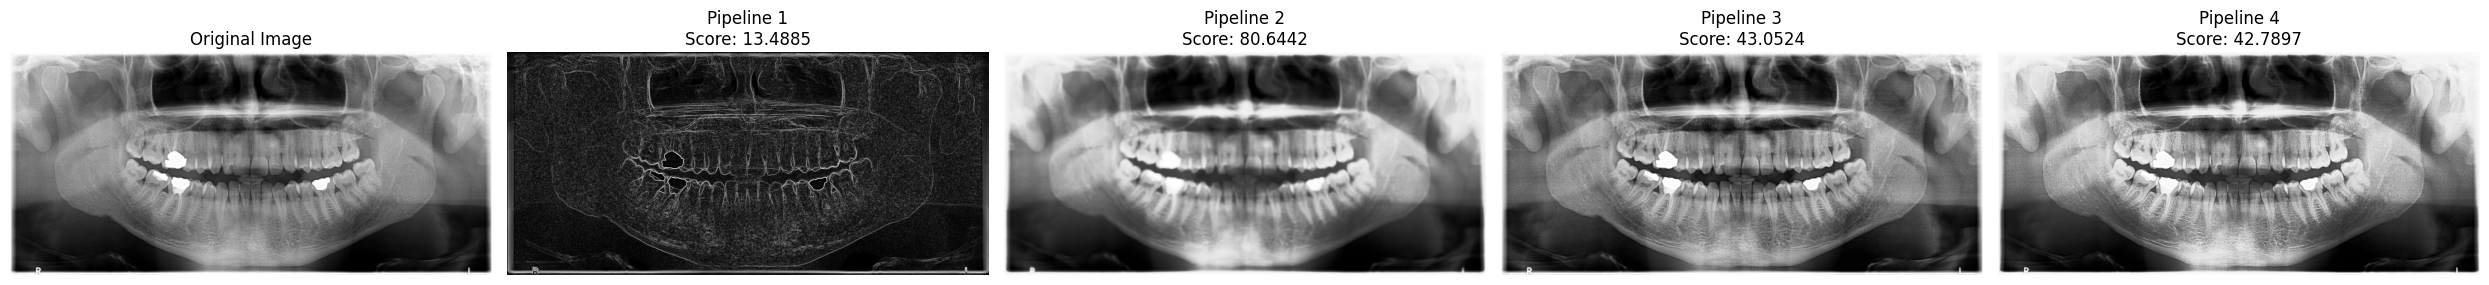

Results for img3.png:
Pipeline 1 Score: 19.8264
Pipeline 2 Score: 82.7092
Pipeline 3 Score: 42.4177
Pipeline 4 Score: 38.9045


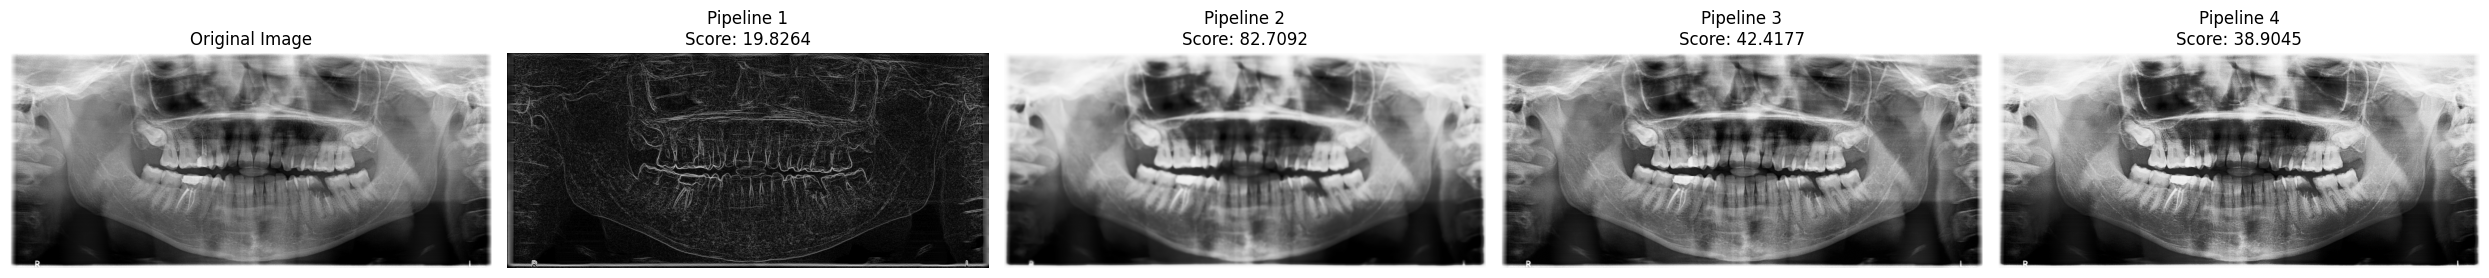

Results for img9.png:
Pipeline 1 Score: 18.3200
Pipeline 2 Score: 83.5930
Pipeline 3 Score: 41.9826
Pipeline 4 Score: 40.0720


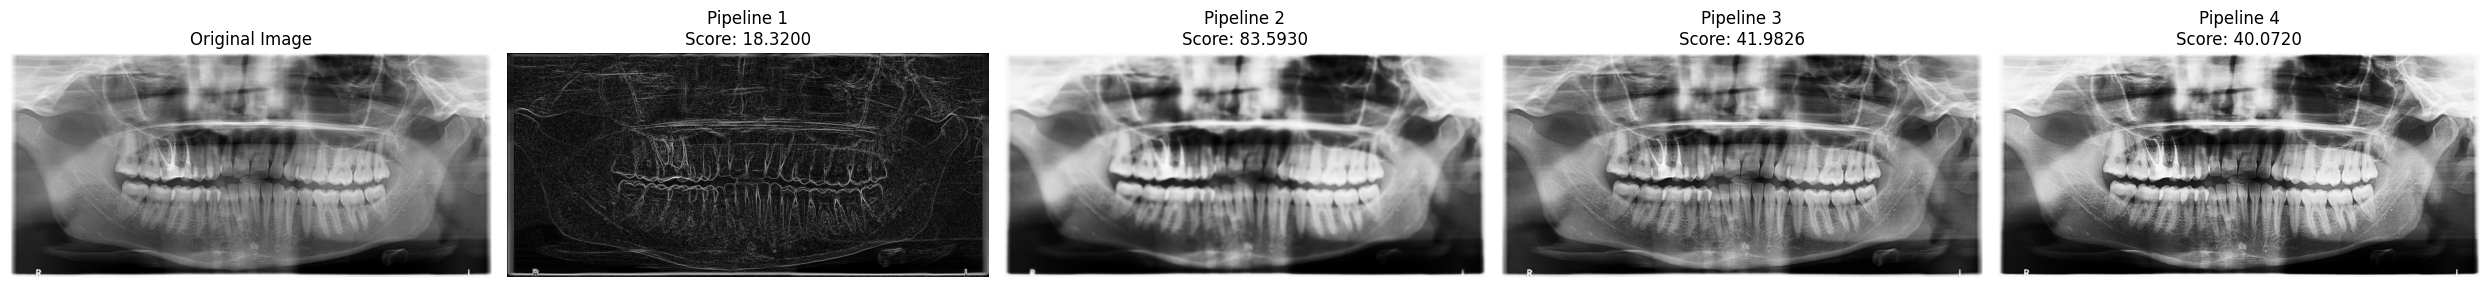

In [ ]:
import numpy as np
import cv2
import torch
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from skimage.filters.rank import entropy
from skimage.morphology import disk
from piq import brisque

# Gaussian Filtreleme
def apply_gaussian_filter(image, sigma=1):
    return gaussian_filter(image, sigma=sigma)

# Bilateral Filtreleme
def apply_bilateral_filter(image, diameter=9, sigma_color=75, sigma_space=75):
    return cv2.bilateralFilter(image, diameter, sigma_color, sigma_space)

# CLAHE uygulama
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

# Keskinleştirme
def unsharp_mask(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

# Normalizasyon
def normalize_image(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image)) * 255

# Histogram Eşitleme
def histogram_equalization(image):
    return cv2.equalizeHist(image.astype(np.uint8))

# Pipeline 1: Normalizasyon -> Medyan Filtre -> Negatif Dönüşüm -> Sobel -> CLAHE
def pipeline_1(image):
    min_val = np.min(image)
    max_val = np.max(image)
    normalized = ((image - min_val) / (max_val - min_val) * 255).astype(np.uint8)
    median_filtered = cv2.medianBlur(normalized, 5)
    negative_transformed = 255 - median_filtered
    sobel_x = cv2.Sobel(negative_transformed, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(negative_transformed, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)
    sobel_enhanced = cv2.convertScaleAbs(sobel_combined)
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
    contrast_enhanced = clahe.apply(sobel_enhanced)
    return contrast_enhanced

# Pipeline 2: Gaussian Blur -> Histogram Eşitleme -> Gama Düzeltme
def pipeline_2(image):
    normalized = normalize_image(image)
    gaussian_blurred = apply_gaussian_filter(normalized, sigma=5)
    histogram_equalized = histogram_equalization(gaussian_blurred)
    gamma_corrected = apply_gaussian_filter(histogram_equalized, sigma=1)
    return gamma_corrected

# Pipeline 3: Median Filter -> CLAHE -> Unsharp Masking
def pipeline_3(image):
    median_filtered = cv2.medianBlur(image.astype(np.uint8), 5)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
    contrast_enhanced = clahe.apply(median_filtered)
    gaussian_smoothed = cv2.GaussianBlur(contrast_enhanced, (3, 3), 0)
    kernel = np.array([[0, -0.5, 0], [-0.5, 3, -0.5], [0, -0.5, 0]])
    sharpened = cv2.filter2D(gaussian_smoothed, -1, kernel)
    return sharpened

# Pipeline 4: Normalization -> Histogram Equalization -> Sharpening -> Gaussian Filter
def pipeline_4(image):
    image = normalize_image(image)
    image = histogram_equalization(image)
    image = sharpen_image(image)
    image = apply_gaussian_filter(image)
    return image

# Sharpening Filter for Pipeline 4
def sharpen_image(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

# Görüntüleri yükle ve işle
image_paths = ["img2.png", "img3.png", "img9.png"]

for image_path in image_paths:
    original_image = cv2.imread(image_path, 0)

    if original_image is None:
        print(f"Error: Unable to read image file: {image_path}")
        continue

    pipeline_1_image = pipeline_1(original_image)
    pipeline_2_image = pipeline_2(original_image)
    pipeline_3_image = pipeline_3(original_image)
    pipeline_4_image = pipeline_4(original_image)

    pipeline_1_tensor = torch.tensor(pipeline_1_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0
    pipeline_2_tensor = torch.tensor(pipeline_2_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0
    pipeline_3_tensor = torch.tensor(pipeline_3_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0
    pipeline_4_tensor = torch.tensor(pipeline_4_image, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0

    pipeline_1_score = brisque(pipeline_1_tensor)
    pipeline_2_score = brisque(pipeline_2_tensor)
    pipeline_3_score = brisque(pipeline_3_tensor)
    pipeline_4_score = brisque(pipeline_4_tensor)

    print(f"Results for {image_path}:")
    print(f"Pipeline 1 Score: {pipeline_1_score:.4f}")
    print(f"Pipeline 2 Score: {pipeline_2_score:.4f}")
    print(f"Pipeline 3 Score: {pipeline_3_score:.4f}")
    print(f"Pipeline 4 Score: {pipeline_4_score:.4f}")

    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(pipeline_1_image, cmap='gray')
    axes[1].set_title(f'Pipeline 1\nScore: {pipeline_1_score:.4f}')
    axes[1].axis('off')

    axes[2].imshow(pipeline_2_image, cmap='gray')
    axes[2].set_title(f'Pipeline 2\nScore: {pipeline_2_score:.4f}')
    axes[2].axis('off')

    axes[3].imshow(pipeline_3_image, cmap='gray')
    axes[3].set_title(f'Pipeline 3\nScore: {pipeline_3_score:.4f}')
    axes[3].axis('off')

    axes[4].imshow(pipeline_4_image, cmap='gray')
    axes[4].set_title(f'Pipeline 4\nScore: {pipeline_4_score:.4f}')
    axes[4].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
!pip install piq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 8.1 MB/s eta 0:00:00


In [ ]:
!pip install scikit-image